In [ ]:
# default_exp data.preparation

# Data preparation

> Functions required to prepare X (and y) from a pandas dataframe.

In [ ]:
#export
from tsai.imports import *
from tsai.utils import *
from tsai.data.validation import *

In [ ]:
#export
def df2xy(df, feat_col=None, target_col=None, data_cols=None, to3d=True, splits=None):
    r"""
    This function allows you to transform a pandas dataframe into X and y numpy arrays that can be used to craete a TSDataset.
    feat_col: used for multivariate datasets. It indicates which is the column that indicates the feature by row.
    target_col: indicates the column/s where the target is.
    data_col: indicates where the data is located. If None, it means all columns (excpet the target)
    """
    no_data_cols = []
    if feat_col is not None: no_data_cols.append(feat_col[0] if is_listy(feat_col) else feat_col)
    if target_col is not None: no_data_cols.append(target_col[0] if is_listy(target_col) else target_col)
    if data_cols is None: data_cols = [col for col in df.columns if col not in no_data_cols]
    n_feats = len(df[feat_col].unique()) if feat_col is not None else 1
    data = df.loc[:, data_cols].values
    _, seq_len = data.shape
    if to3d: X = data.reshape(n_feats, -1, seq_len).transpose(1, 0, 2)
    else: 
        assert feat_col is None, 'When feat_col is not None you must set to3d=True'
        X = data
    if X.dtype == 'O': X = X.astype(np.float32)
    if target_col is not None: y = np.split(df[target_col].values, n_feats)[0]
    else: y = None
    if splits is None: return X, y
    else: return split_xy(X, y, splits)


def split_xy(X, y=None, splits=None):
    if splits is None: 
        if y is not None: return X, y
        else: return X
    if not is_listy(splits[0]): splits = [splits]
    else: assert not is_listy(splits[0][0]), 'You must pass a single set of splits.'
    _X = []
    _y = []
    for split in splits:
        _X.append(X[split])
        if y is not None: _y.append(y[split])
    if len(splits) == 1: return _X[0], _y[0]
    elif len(splits) == 2: return _X[0], _y[0], _X[1], _y[1]
    elif len(splits) == 3: return _X[0], _y[0], _X[1], _y[1], _X[2], _y[2]

In [ ]:
#hide
#old
# def SlidingWindow(window_length, stride:Union[None, int]=1, start:Union[int, None]=0, get_x:Union[None, int, list]=None,  
#                   get_y:Union[None, int, list]=None, horizon:int=0, seq_first:bool=True):
#     """
#     Applies a sliding window to a 1d or 2d input (np.ndarray, torch.Tensor or pd.DataFrame)
    
#     Args:
#         window_length   = length of lookback window
#         stride          = n datapoints the window is moved ahead along the sequence. Default: 1. If None, stride=window_length (no overlap)
#         start           = determines the step where the first window is applied: 0 (default), a given step (int), or random within the 1st stride (None). 
#         horizon         = number of future datapoints to predict. 0 for last step in the selected window. > 0 for future steps. List for several steps.
#         get_x           = indices of columns that contain the independent variable (xs). If None, all data will be used as x
#         get_y           = indices of columns that contain the target (ys). If None and horizon = 0, no y will be returned to avoid leakage.
#         seq_first       = True if input shape (seq_len, n_vars), False if input shape (n_vars, seq_len)
        
        
#     Input:
#         You can use np.ndarray, pd.DataFrame or torch.Tensor as input
#         shape: (seq_len, ) or (seq_len, n_vars) if seq_first=True else (n_vars, seq_len)
#     """
    
#     if type(get_x) == pd.core.indexes.base.Index: get_x = get_x.values
#     if type(get_y) == pd.core.indexes.base.Index: get_y = get_y.values
#     get_x = [get_x] if type(get_x) not in [np.ndarray, torch.Tensor, list, NoneType] else get_x
#     get_y = [get_y] if type(get_y) not in [np.ndarray, torch.Tensor, list, NoneType] else get_y
#     if horizon == 0 and get_x is not None and get_y is not None:
#         assert len([y_idx for y_idx in get_y if y_idx in get_x]) == 0, \
#         'you need to change either horizon, get_x or get_y to avoid leakage'
#     wl = window_length
#     ws = wl if stride is None else stride
#     start = start if start is not None else np.random.choice(ws, 1)[0]
#     def _inner(o):
#         if isinstance(o, pd.DataFrame): 
#             columns = o.columns.values if seq_first else o.T.columns.values
#             o = o.values
#             if o.ndim > 1: 
#                 if get_x is None and get_y is not None: _get_x = [i for i, col in enumerate(columns) if col not in get_y]
#                 elif get_x is not None: _get_x = [i for i, col in enumerate(columns) if col in get_x]
#                 else: _get_x = slice(None)
#                 _get_y = [i for i, col in enumerate(columns) if col in get_y] if get_y is not None else slice(None)
#         elif o.ndim > 1: 
#             _get_x = ifnone(get_x, slice(None))
#             _get_y = ifnone(get_y, slice(None))
#         if seq_first: o = o.T
#         o = o.squeeze()
#         _seq_len = o.shape[-1]
#         assert wl + ws + horizon <= _seq_len, f'window_length + stride + horizon > seq_len ({wl + ws + horizon} > {_seq_len})'
#         x, y = [], []
#         for i in range(start, _seq_len - wl - horizon + 1, ws):
#             if o.ndim == 1: 
#                 x.append(o[..., slice(i, i + wl)])
#                 if get_y is not None or horizon > 0: 
#                     y.append(o[..., slice(i + wl, i + wl + horizon) if horizon else slice(i + wl - 1, i + wl)])
#             else: 
#                 x.append(o[..., _get_x, slice(i, i + wl)])
#                 if get_y is not None or horizon > 0: 
#                     y.append(o[..., _get_y, slice(i + wl, i + wl + horizon) if horizon else slice(i + wl - 1, i + wl)])
#         X = to3d(stack(x))
#         if X.dtype == 'O': X = X.astype(np.float32)
#         y = stack(y).squeeze() if y != [] else None
#         return X, y
#     return _inner

In [ ]:
# #hide
# #old
# def SlidingWindow(window_length:int, stride:Union[None, int]=1, start:Union[int, None]=0, get_x:Union[None, int, list]=None,  
#                   get_y:Union[None, int, list]=None, y_func:Optional[callable]=None, horizon:int=0, seq_first:bool=True, 
#                   sort_by:Optional[list]=None, ascending:bool=True):

#     """
#     Applies a sliding window to a 1d or 2d input (np.ndarray, torch.Tensor or pd.DataFrame)
    
#     Args:
#         window_length   = length of lookback window
#         stride          = n datapoints the window is moved ahead along the sequence. Default: 1. If None, stride=window_length (no overlap)
#         start           = determines the step where the first window is applied: 0 (default), a given step (int), or random within the 1st stride (None). 
#         horizon         = number of future datapoints to predict. 0 for last step in the selected window. > 0 for future steps. List for several steps.
#         get_x           = indices of columns that contain the independent variable (xs). If None, all data will be used as x
#         get_y           = indices of columns that contain the target (ys). If None and horizon = 0, no y will be returned to avoid leakage.
#         y_func          = function to calculate the ys based on the get_y col/s and the last lookback window or the horizon.
#         seq_first       = True if input shape (seq_len, n_vars), False if input shape (n_vars, seq_len)
#         sort_by         = column/s used for sorting the array in ascending order
#         ascending       = used in sorting
        
        
#     Input:
#         You can use np.ndarray, pd.DataFrame or torch.Tensor as input
#         shape: (seq_len, ) or (seq_len, n_vars) if seq_first=True else (n_vars, seq_len)
#     """
    
#     if type(get_x) == pd.core.indexes.base.Index: get_x = get_x.values
#     if type(get_y) == pd.core.indexes.base.Index: get_y = get_y.values
#     get_x = [get_x] if type(get_x) not in [np.ndarray, torch.Tensor, list, NoneType] else get_x
#     get_y = [get_y] if type(get_y) not in [np.ndarray, torch.Tensor, list, NoneType] else get_y
#     if horizon == 0 and get_x is not None and get_y is not None:
#         assert len([y_idx for y_idx in get_y if y_idx in get_x]) == 0, \
#         'you need to change either horizon, get_x or get_y to avoid leakage'
#     wl = window_length
#     ws = wl if stride is None else stride
#     start = start if start is not None else np.random.choice(ws, 1)[0]
#     def _inner(o):
#         if isinstance(o, pd.DataFrame): 
#             if sort_by is not None: o.sort_values(by=sort_by, axis=0, ascending=ascending, inplace=True, ignore_index=True)
#             columns = o.columns.values if seq_first else o.T.columns.values
#             o = o.values
#             if o.ndim > 1: 
#                 if get_x is None and get_y is not None: _get_x = [i for i, col in enumerate(columns) if col not in get_y]
#                 elif get_x is not None: _get_x = [i for i, col in enumerate(columns) if col in get_x]
#                 else: _get_x = slice(None)
#                 _get_y = [i for i, col in enumerate(columns) if col in get_y] if get_y is not None else slice(None)
#         elif o.ndim > 1: 
#             _get_x = ifnone(get_x, slice(None))
#             _get_y = ifnone(get_y, slice(None))
#         if seq_first: o = o.T
#         o = o.squeeze()
#         _seq_len = o.shape[-1]
#         assert wl + ws + horizon <= _seq_len, f'window_length + stride + horizon > seq_len ({wl + ws + horizon} > {_seq_len})'
#         x, y = [], []
#         for i in range(start, _seq_len - wl - horizon + 1, ws):
#             if o.ndim == 1: 
#                 x.append(o[..., slice(i, i + wl)])
#                 if get_y is not None or horizon > 0:
#                     if y_func is not None:
#                         y.append(y_func(o[(..., slice(i + wl, i + wl + horizon)) if horizon else (..., slice(i + wl - 1, i + wl))]))
#                     else: 
#                         y.append(o[(..., slice(i + wl, i + wl + horizon)) if horizon else (..., slice(i + wl - 1, i + wl))])
#             else: 
#                 x.append(o[..., _get_x, slice(i, i + wl)])
#                 if get_y is not None or horizon > 0:
#                     if y_func is not None: 
#                         y.append(y_func(o[(..., _get_y, slice(i + wl, i + wl + horizon)) if horizon else (..., _get_y, slice(i, i + wl))]))
#                     else: 
#                         y.append(o[(..., _get_y, slice(i + wl, i + wl + horizon)) if horizon else (..., _get_y, slice(i + wl - 1, i + wl))])
#         X = to3d(stack(x))
#         if X.dtype == 'O': X = X.astype(np.float32)
#         y = stack(y).squeeze() if y != [] else None
#         return X, y
#     return _inner

In [ ]:
#export
# SlidingWindow vectorization is based on "Fast and Robust Sliding Window Vectorization with NumPy" by Syafiq Kamarul Azman
# https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5


def SlidingWindow(window_len:int, stride:Union[None, int]=1, start:int=0, get_x:Union[None, int, list]=None,  
                  get_y:Union[None, int, list]=None, y_func:Optional[callable]=None, horizon:Union[int, list]=1, seq_first:bool=True, 
                  sort_by:Optional[list]=None, ascending:bool=True, check_leakage:bool=True):

    """
    Applies a sliding window to a 1d or 2d input (np.ndarray, torch.Tensor or pd.DataFrame)
    
    Args:
        window_len      = length of lookback window
        stride          = n datapoints the window is moved ahead along the sequence. Default: 1. If None, stride=window_len (no overlap)
        start           = determines the step where the first window is applied: 0 (default), a given step (int), or random within the 1st stride (None). 
        horizon         = number of future datapoints to predict:
                            * 0 for last step in each sub-window. 
                            * n > 0 for a range of n future steps (1 to n). 
                            * n < 0 for a range of n past steps (-n + 1 to 0).
                            * list : for those exact timesteps.
        get_x           = indices of columns that contain the independent variable (xs). If None, all data will be used as x.
        get_y           = indices of columns that contain the target (ys). If None, all data will be used as y. [] means no y data is created.
        y_func          = function to calculate the ys based on the get_y col/s and each y sub-window. y_func must be a function applied to axis=1!
        seq_first       = True if input shape (seq_len, n_vars), False if input shape (n_vars, seq_len)
        sort_by         = column/s used for sorting the array in ascending order
        ascending       = used in sorting
        check_leakage   = checks if there's leakage in the output between X and y
        
        
    Input:
        You can use np.ndarray, pd.DataFrame or torch.Tensor as input
        shape: (seq_len, ) or (seq_len, n_vars) if seq_first=True else (n_vars, seq_len)
    """

    if horizon == 0: horizon_rng = np.array([0])
    elif is_listy(horizon): horizon_rng = np.array(horizon)
    elif isinstance(horizon, Integral): horizon_rng = np.arange(1, horizon + 1) if horizon > 0 else np.arange(horizon + 1, 1)
    min_horizon = min(horizon_rng)
    max_horizon = max(horizon_rng)
    _get_x = slice(None) if get_x is None else get_x.tolist() if isinstance(get_x, pd.core.indexes.base.Index) else [get_x] if not is_listy(get_x) else get_x
    _get_y = slice(None) if get_y is None else get_y.tolist() if isinstance(get_y, pd.core.indexes.base.Index) else [get_y] if not is_listy(get_y) else get_y
    if min_horizon <= 0 and y_func is None and get_y != [] and check_leakage: 
        assert get_x is not None and  get_y is not None and len([y for y in _get_y if y in _get_x]) == 0,  \
        'you need to change either horizon, get_x, get_y or use a y_func to avoid leakage'
    stride = ifnone(stride, window_len)

    def _inner(o):
        if not seq_first: o = o.T
        if isinstance(o, pd.DataFrame): 
            if sort_by is not None: o.sort_values(by=sort_by, axis=0, ascending=ascending, inplace=True, ignore_index=True)
            X = o.loc[:, _get_x].values if get_x is None or not isinstance(_get_x[0], Integral) else o.iloc[:, _get_x].values
            y = o.loc[:, _get_y].values if get_y is None or not isinstance(_get_y[0], Integral) else o.iloc[:, _get_y].values
        else:
            if isinstance(o, torch.Tensor): o = o.numpy()
            if o.ndim < 2: o = o[:, None]
            X = o[:, _get_x]
            y = o[:, _get_y]
        seq_len = len(X)
        X_max_time = seq_len - start - max_horizon - window_len + 1
        if X_max_time <= 0: return None, None
        X_sub_windows = (start + 
                         np.expand_dims(np.arange(window_len), 0) + # window len
                         np.expand_dims(np.arange(X_max_time, step=stride), 0).T) # # subwindows
        X = np.transpose(X[X_sub_windows], (0, 2, 1))   
        if y is not None and get_y != []:
            y_start = start + window_len - 1
            y_max_time = seq_len - y_start - max_horizon
            y_sub_windows = (y_start + 
                             np.expand_dims(horizon_rng, 0) + # horizon_rng
                             np.expand_dims(np.arange(y_max_time, step=stride), 0).T) # # subwindows
            y = y[y_sub_windows]
            if y_func is not None and len(y) > 0: 
                y = y_func(y)
            if y.ndim >= 2: 
                for d in np.arange(1, y.ndim)[::-1]:
                    if y.shape[d] == 1: y = np.squeeze(y, axis=d)
            return X, y
        else: return X, None
    return _inner

In [ ]:
wl = 5
t = np.arange(10)
print('input shape:', t.shape)
X, y = SlidingWindow(wl)(t)
test_eq(X.shape[1:], (1, wl))
itemify(X,)

input shape: (10,)


(#5) [(array([[0, 1, 2, 3, 4]]),),(array([[1, 2, 3, 4, 5]]),),(array([[2, 3, 4, 5, 6]]),),(array([[3, 4, 5, 6, 7]]),),(array([[4, 5, 6, 7, 8]]),)]

In [ ]:
wl = 5
h = 1

t = np.arange(10)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=1, horizon=h)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (10,)
[(array([[0, 1, 2, 3, 4]]), 5), (array([[1, 2, 3, 4, 5]]), 6), (array([[2, 3, 4, 5, 6]]), 7), (array([[3, 4, 5, 6, 7]]), 8), (array([[4, 5, 6, 7, 8]]), 9)]


In [ ]:
wl = 5
h = 2 # 2 or more

t = np.arange(10)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, horizon=h)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, (2, ))

input shape: (10,)
[(array([[0, 1, 2, 3, 4]]), array([5, 6])), (array([[1, 2, 3, 4, 5]]), array([6, 7])), (array([[2, 3, 4, 5, 6]]), array([7, 8])), (array([[3, 4, 5, 6, 7]]), array([8, 9]))]


In [ ]:
wl = 5
h = 2 # 2 or more

t = np.arange(10).reshape(1, -1)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=1, horizon=h, get_y=None, seq_first=False)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, (2, ))

input shape: (1, 10)
[(array([[0, 1, 2, 3, 4]]), array([5, 6])), (array([[1, 2, 3, 4, 5]]), array([6, 7])), (array([[2, 3, 4, 5, 6]]), array([7, 8])), (array([[3, 4, 5, 6, 7]]), array([8, 9]))]


In [ ]:
wl = 5
h = 2 # 2 or more

t = np.arange(10).reshape(1, -1)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=1, horizon=h, seq_first=False)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))

input shape: (1, 10)
[(array([[0, 1, 2, 3, 4]]), array([5, 6])), (array([[1, 2, 3, 4, 5]]), array([6, 7])), (array([[2, 3, 4, 5, 6]]), array([7, 8])), (array([[3, 4, 5, 6, 7]]), array([8, 9]))]


In [ ]:
wl = 5

t = np.arange(10).reshape(1, -1)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=3, horizon=1, get_y=None, seq_first=False)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (1, 10)
[(array([[0, 1, 2, 3, 4]]), 5), (array([[3, 4, 5, 6, 7]]), 8)]


In [ ]:
wl = 5
start = 3

t = np.arange(20)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=None, horizon=1, start=start)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)
[(array([[3, 4, 5, 6, 7]]), 8), (array([[ 8,  9, 10, 11, 12]]), 13), (array([[13, 14, 15, 16, 17]]), 18)]


In [ ]:
wl = 5

t = np.arange(20)
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=['var'])
display(df)
X, y = SlidingWindow(wl, stride=None, horizon=1, get_y=None)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)


,var
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


[(array([[0, 1, 2, 3, 4]]), 5), (array([[5, 6, 7, 8, 9]]), 10), (array([[10, 11, 12, 13, 14]]), 15)]


In [ ]:
wl = 5

t = np.arange(20)
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=['var'])
display(df)
X, y = SlidingWindow(wl, stride=1, horizon=1, get_y=None)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)


,var
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


[(array([[0, 1, 2, 3, 4]]), 5), (array([[1, 2, 3, 4, 5]]), 6), (array([[2, 3, 4, 5, 6]]), 7), (array([[3, 4, 5, 6, 7]]), 8), (array([[4, 5, 6, 7, 8]]), 9), (array([[5, 6, 7, 8, 9]]), 10), (array([[ 6,  7,  8,  9, 10]]), 11), (array([[ 7,  8,  9, 10, 11]]), 12), (array([[ 8,  9, 10, 11, 12]]), 13), (array([[ 9, 10, 11, 12, 13]]), 14), (array([[10, 11, 12, 13, 14]]), 15), (array([[11, 12, 13, 14, 15]]), 16), (array([[12, 13, 14, 15, 16]]), 17), (array([[13, 14, 15, 16, 17]]), 18), (array([[14, 15, 16, 17, 18]]), 19)]


In [ ]:
wl = 5

t = np.arange(20)
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=['var']).T
display(df)
X, y = SlidingWindow(wl, stride=None, horizon=1, get_y=None, seq_first=False)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
var,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19


[(array([[0, 1, 2, 3, 4]]), 5), (array([[5, 6, 7, 8, 9]]), 10), (array([[10, 11, 12, 13, 14]]), 15)]


In [ ]:
wl = 5
n_vars = 3

t = (torch.stack(n_vars * [torch.arange(10)]).T * tensor([1, 10, 100]))
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=[f'var_{i}' for i in range(n_vars)])
display(df)
X, y = SlidingWindow(wl, horizon=1)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars, wl))

input shape: torch.Size([10, 3])


,var_0,var_1,var_2
0,0,0,0
1,1,10,100
2,2,20,200
3,3,30,300
4,4,40,400
5,5,50,500
6,6,60,600
7,7,70,700
8,8,80,800
9,9,90,900


[(array([[  0,   1,   2,   3,   4],
       [  0,  10,  20,  30,  40],
       [  0, 100, 200, 300, 400]]), array([  5,  50, 500])), (array([[  1,   2,   3,   4,   5],
       [ 10,  20,  30,  40,  50],
       [100, 200, 300, 400, 500]]), array([  6,  60, 600])), (array([[  2,   3,   4,   5,   6],
       [ 20,  30,  40,  50,  60],
       [200, 300, 400, 500, 600]]), array([  7,  70, 700])), (array([[  3,   4,   5,   6,   7],
       [ 30,  40,  50,  60,  70],
       [300, 400, 500, 600, 700]]), array([  8,  80, 800])), (array([[  4,   5,   6,   7,   8],
       [ 40,  50,  60,  70,  80],
       [400, 500, 600, 700, 800]]), array([  9,  90, 900]))]


In [ ]:
wl = 5
n_vars = 3

t = (torch.stack(n_vars * [torch.arange(10)]).T * tensor([1, 10, 100]))
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=[f'var_{i}' for i in range(n_vars)])
display(df)
X, y = SlidingWindow(wl, horizon=1, get_y=0)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars, wl))

input shape: torch.Size([10, 3])


,var_0,var_1,var_2
0,0,0,0
1,1,10,100
2,2,20,200
3,3,30,300
4,4,40,400
5,5,50,500
6,6,60,600
7,7,70,700
8,8,80,800
9,9,90,900


[(array([[  0,   1,   2,   3,   4],
       [  0,  10,  20,  30,  40],
       [  0, 100, 200, 300, 400]]), 5), (array([[  1,   2,   3,   4,   5],
       [ 10,  20,  30,  40,  50],
       [100, 200, 300, 400, 500]]), 6), (array([[  2,   3,   4,   5,   6],
       [ 20,  30,  40,  50,  60],
       [200, 300, 400, 500, 600]]), 7), (array([[  3,   4,   5,   6,   7],
       [ 30,  40,  50,  60,  70],
       [300, 400, 500, 600, 700]]), 8), (array([[  4,   5,   6,   7,   8],
       [ 40,  50,  60,  70,  80],
       [400, 500, 600, 700, 800]]), 9)]


In [ ]:
wl = 5
n_vars = 3

t = (torch.stack(n_vars * [torch.arange(10)]).T * tensor([1, 10, 100]))
print('input shape:', t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(wl, horizon=1, get_x=columns[:-1], get_y='target')(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars-1, wl))
test_eq(items[0][1].shape, ())

input shape: torch.Size([10, 3])


,var_0,var_1,target
0,0,0,0
1,1,10,100
2,2,20,200
3,3,30,300
4,4,40,400
5,5,50,500
6,6,60,600
7,7,70,700
8,8,80,800
9,9,90,900


[(array([[ 0,  1,  2,  3,  4],
       [ 0, 10, 20, 30, 40]]), 500), (array([[ 1,  2,  3,  4,  5],
       [10, 20, 30, 40, 50]]), 600), (array([[ 2,  3,  4,  5,  6],
       [20, 30, 40, 50, 60]]), 700), (array([[ 3,  4,  5,  6,  7],
       [30, 40, 50, 60, 70]]), 800), (array([[ 4,  5,  6,  7,  8],
       [40, 50, 60, 70, 80]]), 900)]


(1000, 3)


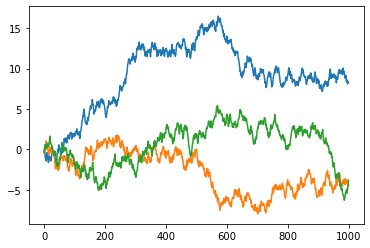

(200, 2, 5) (200,)


In [ ]:
n_vars = 3

t = (np.random.rand(1000, n_vars) - .5).cumsum(0)
print(t.shape)
plt.plot(t)
plt.show()
X, y = SlidingWindow(5, stride=None, horizon=0, get_x=[0,1], get_y=2)(t)
test_eq(X[0].shape, (n_vars-1, wl))
test_eq(y[0].shape, ())
print(X.shape, y.shape)

In [ ]:
wl = 5
n_vars = 3

t = (np.random.rand(100, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(5, horizon=0, get_x=columns[:-1], get_y='target')(df)
test_eq(X[0].shape, (n_vars-1, wl))
test_eq(y[0].shape, ())
print(X.shape, y.shape)

(100, 3)


,var_0,var_1,target
0,0.038634,0.293615,0.130515
1,0.248407,0.500844,0.271745
2,0.541690,0.569672,-0.055736
3,0.316472,0.700625,-0.270632
4,0.031140,1.097332,-0.444498
...,...,...,...
95,2.356627,2.934182,-2.219459
96,2.368038,2.805027,-2.635984
97,1.918877,3.143798,-2.364252
98,2.101522,3.618043,-2.641366


(96, 2, 5) (96,)


In [ ]:
seq_len = 100
n_vars = 5
t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(5, stride=1, horizon=0, get_x=columns[:-1], get_y='target', seq_first=True)(df)
test_eq(X[0].shape, (n_vars-1, wl))
test_eq(y[0].shape, ())
print(X.shape, y.shape)

(100, 5)


,var_0,var_1,var_2,var_3,target
0,0.339953,-0.231598,-0.158507,-0.376152,0.188453
1,0.518264,-0.433457,-0.137378,-0.121059,0.197342
2,0.655277,-0.763794,-0.077140,-0.200773,-0.022643
3,0.356016,-1.168285,-0.080036,-0.544722,0.434156
4,0.601960,-0.679113,-0.425577,-0.990450,0.400938
...,...,...,...,...,...
95,-2.182325,-3.350593,-0.949227,3.391806,0.779867
96,-2.107819,-2.893040,-0.484622,3.232320,0.685009
97,-1.809907,-2.531993,-0.671675,3.317745,0.913918
98,-2.114518,-2.168623,-0.412025,3.351040,1.402285


(96, 4, 5) (96,)


In [ ]:
seq_len = 100
n_vars = 5

t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)] + ['target']
df = pd.DataFrame(t, columns=columns).T
display(df)
X, y = SlidingWindow(5, stride=1, horizon=0, get_x=columns[:-1], get_y='target', seq_first=False)(df)
test_eq(X[0].shape, (n_vars-1, wl))
test_eq(y[0].shape, ())
print(X.shape, y.shape)

(100, 5)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
var_0,-0.296422,-0.004598,0.164111,-0.237543,-0.667590,-0.320405,-0.143456,-0.143698,-0.421195,-0.603614,...,-0.971976,-1.370836,-1.225850,-1.025264,-0.877219,-1.204666,-0.722083,-1.077655,-1.454563,-1.050101
var_1,-0.422348,-0.877977,-0.787166,-0.334545,-0.237831,-0.452418,-0.363222,-0.236866,0.101535,0.074536,...,4.566848,4.674314,4.478981,4.082767,3.834859,3.379363,3.399050,3.161341,3.516137,3.254749
var_2,-0.231705,-0.616732,-0.698399,-0.610528,-0.781778,-1.030269,-1.340659,-1.216868,-1.275779,-0.972224,...,-3.558979,-3.288104,-3.229873,-2.750648,-3.196679,-3.194926,-3.475573,-3.428084,-3.328320,-3.607683
var_3,0.075769,0.560160,1.028164,1.121660,1.061583,0.952929,0.676947,0.847203,0.649054,0.899144,...,2.645536,2.177091,2.581504,2.329453,2.760319,3.118379,3.301651,3.690350,3.774698,3.806809
target,0.142767,0.206992,0.381485,0.316006,0.688819,1.021476,0.713747,0.802290,0.629953,1.000925,...,-0.389506,-0.009419,-0.020136,0.427063,0.388512,0.456088,0.203047,-0.000248,-0.336566,-0.596576


(96, 4, 5) (96,)


In [ ]:
seq_len = 100
n_vars = 5
t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)] + ['target']
df = pd.DataFrame(t, columns=columns).T
display(df)
X, y = SlidingWindow(5, stride=None, horizon=0, get_x=columns[:-1], get_y='target', seq_first=False)(df)
test_eq(X[0].shape, (n_vars-1, wl))
test_eq(y[0].shape, ())
print(X.shape, y.shape)

(100, 5)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
var_0,0.338265,-0.040953,0.242118,-0.197752,-0.576452,-0.260678,-0.239231,-0.012505,0.120454,-0.354439,...,1.490092,1.253580,1.721258,1.488228,1.802736,1.923919,2.304937,2.284354,2.281791,2.116329
var_1,-0.291316,0.201609,0.672053,1.133244,1.170812,1.242230,1.210180,0.812463,0.867917,0.624656,...,-0.992298,-1.358868,-1.523304,-1.501742,-1.802612,-1.934327,-2.048853,-2.142365,-1.943028,-1.896114
var_2,-0.432033,-0.741836,-0.256991,0.011420,-0.143199,-0.467257,-0.740336,-0.807564,-1.121559,-1.081806,...,-3.053388,-2.626260,-2.612326,-2.848860,-2.362454,-1.905001,-1.770754,-1.327158,-1.392714,-0.932734
var_3,-0.284943,-0.433715,-0.161271,-0.633758,-0.692747,-1.008369,-0.794490,-1.240046,-1.510646,-1.264417,...,-1.958702,-1.794524,-1.523518,-1.038033,-1.007817,-1.046740,-0.579652,-0.138143,0.349164,-0.098881
target,0.236508,0.280994,0.695287,0.897777,0.542729,0.633145,0.214734,0.271708,0.421036,0.792487,...,0.699957,1.095765,1.590161,1.915267,2.182267,1.797175,1.917014,2.205364,1.716323,1.360022


(20, 4, 5) (20,)


In [ ]:
seq_len = 100
n_vars = 5
t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(5, stride=1, horizon=0, get_x=columns[:-1], get_y='target', seq_first=True)(df)
splits = TrainValidTestSplitter(valid_size=.2, shuffle=False)(y)
X.shape, y.shape, splits

(100, 5)


,var_0,var_1,var_2,var_3,target
0,0.206897,-0.392468,-0.312597,-0.136980,0.348403
1,0.663572,0.083953,-0.433040,-0.093337,0.154357
2,1.006646,-0.397654,-0.662023,0.342574,-0.295306
3,0.723478,-0.135558,-0.311356,0.366897,0.055818
4,0.572234,0.013035,-0.629302,0.583496,0.326354
...,...,...,...,...,...
95,-0.045156,-0.867526,3.110634,1.365687,-2.138259
96,0.321400,-1.209710,3.314232,1.181084,-1.785342
97,0.510964,-0.998249,3.440313,1.448730,-1.505673
98,0.684856,-1.487015,3.247855,1.375452,-1.342623


((96, 4, 5),
 (96,),
 ((#77) [0,1,2,3,4,5,6,7,8,9...], (#19) [77,78,79,80,81,82,83,84,85,86...]))

In [ ]:
#export
def SlidingWindowPanel(window_len:int, unique_id_cols:list, stride:Union[None, int]=1, start:int=0, get_x:Union[None, int, list]=None,  
                       get_y:Union[None, int, list]=None, y_func:Optional[callable]=None, horizon:Union[int, list]=1, seq_first:bool=True, 
                       sort_by:Optional[list]=None, ascending:bool=True, check_leakage:bool=True, return_key:bool=False, verbose:bool=True):

    """
    Applies a sliding window to a pd.DataFrame.
    
    Args:
        window_len      = length of lookback window
        unique_id_cols  = pd.DataFrame columns that will be used to identify a time series for each entity.
        stride          = n datapoints the window is moved ahead along the sequence. Default: 1. If None, stride=window_len (no overlap)
        start           = determines the step where the first window is applied: 0 (default), a given step (int), or random within the 1st stride (None). 
        horizon         = number of future datapoints to predict:
                            * 0 for last step in each sub-window. 
                            * n > 0 for a range of n future steps (1 to n). 
                            * n < 0 for a range of n past steps (-n + 1 to 0).
                            * list : for those exact timesteps.
        get_x           = indices of columns that contain the independent variable (xs). If None, all data will be used as x.
        get_y           = indices of columns that contain the target (ys). If None, all data will be used as y. [] means no y data is created.
        y_func          = function to calculate the ys based on the get_y col/s and each y sub-window. y_func must be a function applied to axis=1!
        seq_first       = True if input shape (seq_len, n_vars), False if input shape (n_vars, seq_len)
        sort_by         = column/s used for sorting the array in ascending order
        ascending       = used in sorting
        check_leakage   = checks if there's leakage in the output between X and y
        return_key      = when True, the key corresponsing to unique_id_cols for each sample is returned
        
        
    Input:
        You can use np.ndarray, pd.DataFrame or torch.Tensor as input
        shape: (seq_len, ) or (seq_len, n_vars) if seq_first=True else (n_vars, seq_len)
    """
    
    sort_by = unique_id_cols + (sort_by if sort_by is not None else [])
    
    def _SlidingWindowPanel(df):
        
        df.sort_values(by=sort_by, axis=0, ascending=ascending, inplace=True, ignore_index=True)
        unique_id_values = df[unique_id_cols].drop_duplicates().values
        _x = []
        _y = []
        _key = []
        for i, v in enumerate(progress_bar(unique_id_values)):
            x_v, y_v = SlidingWindow(window_len, stride=stride, start=start, get_x=get_x, get_y=get_y, y_func=y_func, 
                                     horizon=horizon, seq_first=seq_first, check_leakage=check_leakage)(df[(df[unique_id_cols].values == v).sum(axis=1) == len(v)])                                
            if x_v is not None and len(x_v) > 0: 
                _x.append(x_v)
                if return_key: _key.append([v.tolist()] * len(x_v))
                if y_v is not None and len(y_v) > 0: _y.append(y_v)
            else: pv(f'cannot use {unique_id_cols} = {v} due to not having enough records', verbose)

        X = np.concatenate(_x)
        if _y != []:
            y = np.concatenate(_y)
            for d in np.arange(1, y.ndim)[::-1]:
                if y.shape[d] == 1: y = np.squeeze(y, axis=d)
        else: y = None
        if return_key: 
            key = np.concatenate(_key)
            if key.ndim == 2 and key.shape[-1] == 1: key = np.squeeze(key, -1)
            if return_key: return X, y, key
        else: return X, y
        
    return _SlidingWindowPanel

In [ ]:
samples = 100_000
wl = 5
n_vars = 10

t = (torch.stack(n_vars * [torch.arange(samples)]).T * tensor([10**i for i in range(n_vars)]))
df = pd.DataFrame(t, columns=[f'var_{i}' for i in range(n_vars)])
df['time'] = np.arange(len(t))
df['device'] = 0
df['target'] = np.random.randint(0, 2, len(df))
df2 = df.copy()
df3 = df.copy()
cols = ['var_0', 'var_1', 'var_2', 'device', 'target']
df2[cols] = df2[cols] + 1
df3[cols] = df3[cols] + 2
df2 = df2.loc[:3]
df['region'] = 'A'
df2['region'] = 'A'
df3['region'] = 'B'
df = df.append(df2).append(df3).reset_index(drop=True)
df['index'] = np.arange(len(df))
df = df.sample(frac=1).reset_index(drop=True)
display(df.head())
df.shape

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,time,device,target,region,index
0,40803,408012,4080102,40801000,408010000,4080100000,40801000000,408010000000,4080100000000,40801000000000,40801,2,3,B,140805
1,13059,130572,1305702,13057000,130570000,1305700000,13057000000,130570000000,1305700000000,13057000000000,13057,2,3,B,113061
2,19269,192690,1926900,19269000,192690000,1926900000,19269000000,192690000000,1926900000000,19269000000000,19269,0,0,A,19269
3,10925,109250,1092500,10925000,109250000,1092500000,10925000000,109250000000,1092500000000,10925000000000,10925,0,0,A,10925
4,62408,624080,6240800,62408000,624080000,6240800000,62408000000,624080000000,6240800000000,62408000000000,62408,0,0,A,62408


(200004, 15)

In [ ]:
X, y = SlidingWindowPanel(window_len=5, unique_id_cols=['device'], stride=1, start=0, get_x=df.columns[:n_vars], get_y=['target'], 
                          horizon=0, seq_first=True, sort_by=['time'], ascending=True, return_key=False)(df)
X.shape, y.shape

cannot use ['device'] = [1] due to not having enough records


((199992, 10, 5), (199992,))

In [ ]:
X, y, key = SlidingWindowPanel(window_len=5, unique_id_cols=['device'], stride=1, start=0, get_x=df.columns[:n_vars], get_y=['target'], 
                               horizon=0, seq_first=True, sort_by=['time'], ascending=True, return_key=True)(df)
X.shape, y.shape, key.shape

cannot use ['device'] = [1] due to not having enough records


((199992, 10, 5), (199992,), (199992,))

In [ ]:
X, y = SlidingWindowPanel(window_len=5, unique_id_cols=['device', 'region'], stride=1, start=0, get_x=df.columns[:n_vars], get_y=['target'], 
                          horizon=0, seq_first=True, sort_by=['time'], ascending=True)(df)
X.shape, y.shape

cannot use ['device', 'region'] = [1 'A'] due to not having enough records


((199992, 10, 5), (199992,))

In [ ]:
# y_func must be a function applied to axis=1!
def y_max(o): return np.max(o, axis=1)

In [ ]:
X, y = SlidingWindowPanel(window_len=5, unique_id_cols=['device', 'region'], stride=1, start=0, get_x=df.columns[:n_vars], get_y=['target'], 
                          y_func=y_max, horizon=5, seq_first=True, sort_by=['time'], ascending=True)(df)
X.shape, y.shape

cannot use ['device', 'region'] = [1 'A'] due to not having enough records


((199982, 10, 5), (199982,))

In [ ]:
#hide
out = create_scripts(); beep(out)

<IPython.core.display.Javascript object>

Converted 000_utils.ipynb.
Converted 000b_data.validation.ipynb.
Converted 000c_data.preparation.ipynb.
Converted 001_data.external.ipynb.
Converted 002_data.core.ipynb.
Converted 003_data.preprocessing.ipynb.
Converted 003b_data.transforms.ipynb.
Converted 003c_data.mixed_augmentation.ipynb.
Converted 003d_data.image.ipynb.
Converted 003e_data.features.ipynb.
Converted 005_data.tabular.ipynb.
Converted 006_data.mixed.ipynb.
Converted 007_metrics.ipynb.
Converted 008_learner.ipynb.
Converted 009_optimizer.ipynb.
Converted 010_callback.core.ipynb.
Converted 011_callback.noisy_student.ipynb.
Converted 012_callback.gblend.ipynb.
Converted 013_callback.TSBERT.ipynb.
Converted 100_models.utils.ipynb.
Converted 100b_models.layers.ipynb.
Converted 100c_models.explainability.ipynb.
Converted 101_models.ResNet.ipynb.
Converted 101b_models.ResNetPlus.ipynb.
Converted 102_models.InceptionTime.ipynb.
Converted 102b_models.InceptionTimePlus.ipynb.
Converted 103_models.MLP.ipynb.
Converted 103b_mode